<h4>The Essence of Model Architecture</h4>
<p>A model's <b>architecture</b> is the culmination of all design decisions: the layers chosen, their configurations, and how they connect. These choices fundamentally define the model's <b>hypothesis space</b>—the set of all possible functions that the optimization algorithm, like gradient descent, can explore. Much like feature engineering, a well-defined hypothesis space incorporates crucial prior knowledge about the problem, such as the assumption of translation invariance when using convolutional layers for image data. To learn effectively, a model must be guided by these underlying assumptions.</p>
<p>
<li>In machine learning, a hypothesis (often denoted as h(x)) is a specific function or model that maps input features (x) to output predictions (y). It's a candidate solution that the learning algorithm is trying to find.</li>
For example:
<li>In linear regression, a hypothesis might be h(x)= w1x1 + w2x2 +b. </li>
<li>In a decision tree, a hypothesis is a specific set of rules or splits that lead to a prediction. </li>
<li>In a neural network, a hypothesis is the entire trained network, including its architecture (number of layers, neurons, activation functions) and all its learned weights and biases.</li>
</p>
<h4>Impact on Success</h4>
<p>Model architecture is frequently the key differentiator between success and failure. Inappropriate architectural choices can lead to perpetually suboptimal performance, regardless of the amount of training data. Conversely, a strong architecture can significantly accelerate learning and enable efficient use of available training data, potentially reducing the need for massive datasets.We will now explore key convnet architecture best practices: <b>residual connections, batch normalization, and separable convolutions.</b> Mastering these techniques is essential for building highly effective image models.</p>

<h4>Module-hierarchy-reuse</h4>

<p>Deep learning applies gradient descent to continuous optimization by structuring the search space into a deep hierarchy of reusable modules (layers). This modularity, hierarchy, and reuse are central to effective deep learning model architecture.

Popular convnet architectures exemplify this by organizing layers into repeated "blocks" or "modules." For instance, VGG16 uses recurring "conv, conv, max pooling" blocks.</p>

Furthermore, most convnets feature pyramid-like structures or feature hierarchies. This is evident in the typical progression of convolution filters, where the number of filters increases with layer depth (e.g., 32, 64, 128), while the feature map size concurrently shrinks.

<h2 style="color: red">Residual connection</h2>
<p>Backpropagation in deep sequential models works by transmitting error information from the output of the final function (<code>f4</code> in <code>y = f4(f3(f2(f1(x))))</code>) needs to propagate back through each function to adjust its parameters from f4 -> f3 -> f2 -> f1. However, each function in a deep chain can introduce some amount of noise. If your function chain is too deep, this noise starts overwhelming gradient information, and backpropagation stops working entirely. Your model won’t train at all. This is known as the <b>vanishing gradients problem</b>.</p>

<p>The solution is to make each function "nondestructive" by using a residual connection. This involves adding the input of a layer or block directly to its output, creating an "information shortcut." This shortcut allows error gradients to bypass destructive or noisy blocks (like those with ReLU activations or dropout) and propagate cleanly through the deep network, ensuring effective training.</p>
<code>
    x = ... [some input tensor]
    residual = x [Save a pointer to the original input. This is called the residual.]
    x = block(x) [This computation block can potentially be destructive or noisy]
    x = add([x, residual]) [Add the original input to the layer’s output: the final output will thus always preserve full information about the original input.]
</code>
<p>When implementing residual connections, a crucial consideration is that the output shape of a block must match its input shape for the addition to work. This isn't always the case, especially if the block contains convolutional layers that increase the number of filters or a max pooling layer that downsamples the spatial dimensions.

When working with residual connections, if a block's output shape doesn't match its input (e.g., due to increased filters or max pooling), use a 1x1 Conv2D layer with no activation to linearly project the residual to the correct output shape. Additionally, employ padding="same" in the block's convolutional layers to prevent spatial downsampling from padding, and use strides in the residual projection to align with any downsampling caused by max pooling within the block.</p>

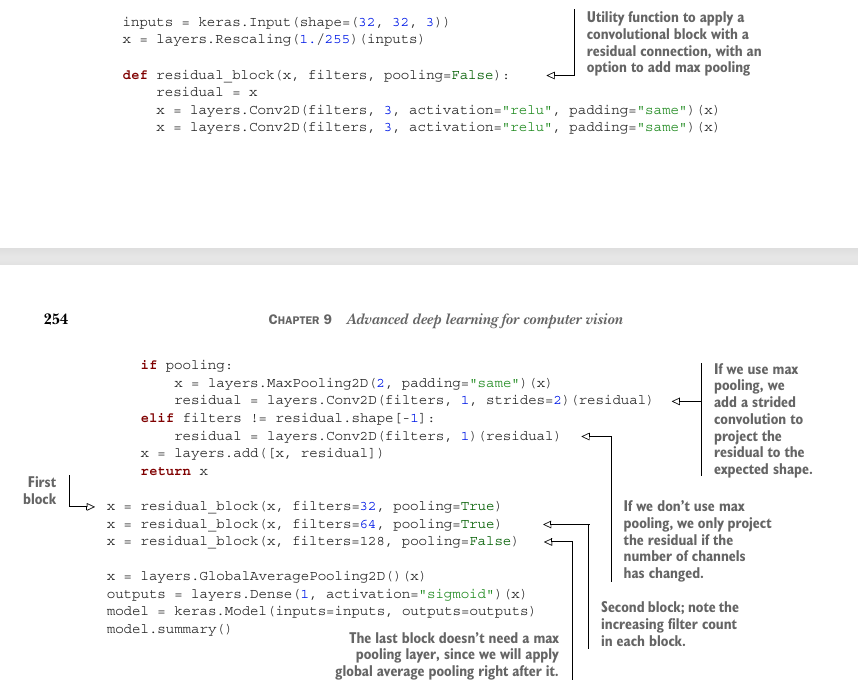

In [5]:
import keras
from keras import layers

inputs = keras.Input(shape=(32, 32, 3))
x = layers.Rescaling(1./255)(inputs)

def residual_block(x, filters, pooling=False):
    residual = x # Set aside the residual.
    
    x = layers.Conv2D(filters, 3, activation="relu", padding="same")(x)
    x = layers.Conv2D(filters, 3, activation="relu", padding="same")(x)
    if pooling:
        x = layers.MaxPooling2D(2, padding="same")(x)
        # If we use max pooling, we add a strided convolution to project the residual to the expected shape.
        residual = layers.Conv2D(filters, 1, strides=2)(residual)
    elif filters != residual.shape[-1]:
        # If we don’t use max pooling, we only project the residual if the number of channels has changed.
        residual = layers.Conv2D(filters, 1)(residual)
    x = layers.add([x, residual])
    return x

x = residual_block(x, filters=32, pooling=True)
x = residual_block(x, filters=64, pooling=True)
x = residual_block(x, filters=128, pooling=False)

x = layers.GlobalAveragePooling2D()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 32, 32, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 32, 32, 3) │          0 │ input_layer[0][0] │
│ (Rescaling)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 32, 32,    │        896 │ rescaling[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 32, 32,    │      9,248 │ conv2d[0][0]      │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 16, 16,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 16, 16,    │        128 │ rescaling[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 16, 16,    │          0 │ max_pooling2d[0]… │
│                     │ 32)               │            │ conv2d_2[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 16, 16,    │     18,496 │ add[0][0]         │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 16, 16,    │     36,928 │ conv2d_3[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 8, 8, 64)  │          0 │ conv2d_4[0][0]    │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 8, 8, 64)  │      2,112 │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 8, 8, 64)  │          0 │ max_pooling2d_1[… │
│                     │                   │            │ conv2d_5[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 8, 8, 128) │     73,856 │ add_1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 8, 8, 128) │    147,584 │ conv2d_6[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 8, 8, 128) │      8,320 │ add_1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 8, 8, 128) │          0 │ conv2d_7[0][0],   │
│                     │                   │            │ conv2d_8[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 128)       │          0 │ add_2[0][0]       │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 1)         │        129 │ global_average_p… │
└─────────────────────┴───────────────────┴────────────┴─────────────────

 Total params: 297,697 (1.14 MB)

 Trainable params: 297,697 (1.14 MB)

 Non-trainable params: 0 (0.00 B)

##### With residual connections, you can build networks of arbitrary depth, without having to worry about vanishing gradients.

<h2 style="color: red">Batch Normalization</h2>
<p>Normalization typically involves scaling input values to have a mean of zero and a standard deviation of one, or to a specific range (e.g., 0 to 1). This is often done by subtracting the mean and dividing by the standard deviation (z-score normalization) or by scaling values to a desired range (min-max scaling).
By bringing features to a similar scale, normalization ensures that all features contribute equally to the learning process, leading to more effective and stable model training. <b>centering the data on zero by subtracting the mean from the data, and giving the data a unit standard deviation by dividing the data by its standard deviation.</b>

Normalization in neural networks is a preprocessing technique that helps to prepare the data for training, making it more robust and efficient. 
</p>
<code>
    normalized_data = (data- np.mean(data, axis=...)) / np.std(data, axis=...)
</code>
<p>
    In neural networks, we usually normalize the data before feeding it into the model. This means adjusting it so it has a mean of 0 and a variance of 1. But even if the initial data is normalized, there's no guarantee that the data coming out of each layer within the network will stay that way.

This is where Batch Normalization comes in. It's a special type of layer that helps by continuously re-normalizing the data after each transformation within the network. This keeps the data's mean close to 0 and its variance close to 1, even as the network learns and its internal values change.

During training, Batch Normalization uses the average (mean) and spread (variance) of the current batch of data to do this normalization. When the model is actually being used (for "inference"), it uses an average of the means and variances it saw during the entire training process.

While the exact reason why Batch Normalization works so well isn't fully understood (it's one of those deep learning mysteries!), its main benefit seems to be that it helps gradients propagate more effectively through the network. This is similar to how residual connections help, and it allows us to train much deeper networks than would otherwise be possible. You'll find Batch Normalization layers used extensively in many advanced CNN architectures.

You can place a BatchNormalization layer after almost any other layer (like Dense or Conv2D). A common best practice is to put the Batch Normalization layer before the activation function (like ReLU). The idea is that Batch Normalization centers the data around zero, which maximizes how much the ReLU activation can actually "do" since ReLU uses zero as a pivot. However, this order isn't strictly critical; your model will likely still train well even if you put the activation before Batch Normalization.
</p>

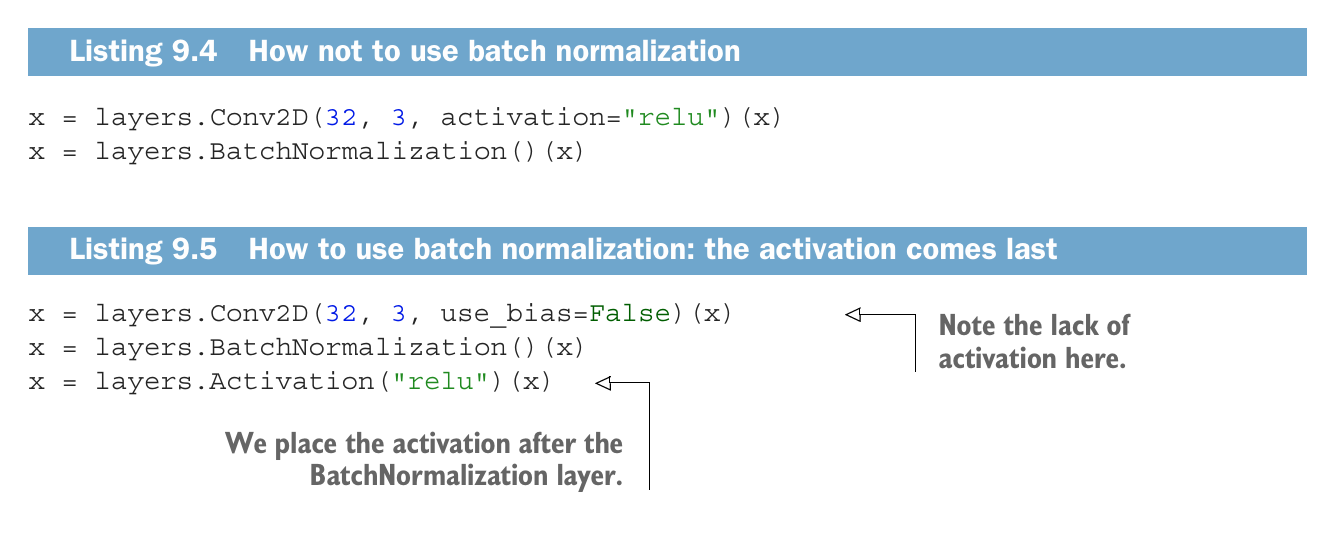

<h2 style="color: red">Depthwise separable convolutions</h2>

<p>Imagine you have a magic building block for your neural network called a <b>depthwise separable convolution</b> (in Keras, it's <code>SeparableConv2D</code>). What's so great about it?</p>

<p>Well, it's like a smarter, more efficient version of the standard <code>Conv2D</code> layer. Here's why:</p>

<ul>
    <li><b>It's Smaller and Faster:</b> It uses fewer trainable parameters (weights) and performs fewer calculations. This means your model is "lighter" and can run quicker.</li>
    <li><b>It Performs Better:</b> Surprisingly, even though it's more efficient, it often helps your model achieve a few percentage points better accuracy on its task.</li>
</ul>

<h3>How Does It Work?</h3>
<p>Instead of doing one big convolution, it breaks the process into two clever steps:</p>
<ol>
    <li><b>Spatial Learning (Depthwise Convolution):</b> It first performs a separate convolution on <i>each individual color channel</i> (like red, green, blue) of your input image, independently. This helps it learn spatial features within each channel.</li>
    <li><b>Channel Mixing (Pointwise Convolution):</b> After that, it uses a simple <b>1x1 convolution</b> (which is like a tiny filter that only looks at one pixel across all channels) to mix the information from these different channels together.</li>
</ol>
<p>Think of it like this: a regular convolution tries to learn both "where features are" and "how channels combine" all at once. A depthwise separable convolution separates these two jobs.</p>

<h3>Why is This Good?</h3>
<p>This separation works well because of a common assumption in image processing:</p>
<ul>
    <li><b>Spatial locations are highly related:</b> What's happening in one part of an image is often connected to what's happening nearby, regardless of the color channel.</li>
    <li><b>Channels can be somewhat independent:</b> Different color channels might carry distinct information that doesn't need to be tightly mixed <i>during</i> the initial spatial learning.</li>
</ul>
<p>By making this "smart assumption" (or <b>prior knowledge</b>), the model becomes more efficient at learning from data. It's like giving the model a head start because you've already simplified part of the problem for it.</p>
<p>The result? Smaller models that learn faster and are less likely to <b>overfit</b> (memorize the training data instead of understanding it). This is especially useful when you don't have a huge amount of data.</p>
<p>Depthwise separable convolutions are a core component of powerful modern CNNs like the <b>Xception architecture</b>, demonstrating their effectiveness in large-scale applications too.</p>